### 


# **機械学習ワークショップで「回帰分析」を体験しよう**
本学習コンテンツでは、一般的な分析手法である「回帰分析」に関して学習する. 特に以下の点について学習する．


**学習のポイント**
- 目的変数と多数の説明変数からなる回帰分析の概念について
- 回帰分析における線形モデルと非線形モデルの違いについて
- 回帰分析の評価方法とモデルの解釈にについて

## まずは今回の解析に必要なライブラリをインストールします

In [1]:
#1 
#今日のワークショップに必要なライブラリです
!echo y | pip install pandas_profiling
!echo y | pip install lightgbm
!echo y | pip install ipywidgets jupyterlab matplotlib
!echo y | pip install pandas==1.3.5

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils 

In [2]:
#2
### 今回のワークショップに必要なメタデータを読み込みます
!echo y | conda install -c conda-forge shap

Solving environment: done

# All requested packages already installed.



In [3]:
#3
#今日のワークショップに必要なPythonモジュールです。
import pandas as pd 
import numpy as np
import pandas_profiling as pdp
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import ElasticNet
import lightgbm as lgb
from matplotlib import pyplot as plt
%matplotlib inline

import shap 
import plotly.graph_objects as go
shap.initjs()

### 目次
1. 学習で使う問題設定とデータセット
2. データ確認のポイント
3. 線形・非線形モデルの違い
4. モデルの評価・解釈
5. 参考文献
---

### **1. 学習で使う問題設定とデータセット**

**1-1. 問題設定：Boston Housing**\
1970年代後半における米国マサチューセッツ州ボストンの住宅価格の予測を行う問題である。データセットに含まれる住宅属性（部屋数や年数など）や地域環境（犯罪率やアクセス性など）などから住宅価格を予測する。

**1-2. データセット詳細**

506件の住宅価格の「表形式データ（部屋数や犯罪率などの13項目）」＋「ラベル（住宅価格）」

| 変数 |データの説明|
| :----|:----------|
| CRIM| 町別の「犯罪率」|
|　ZN | 25,000平方フィートを超える区画に分類される住宅地の割合＝「広い家の割合」|
|　INDUS | 町別の「非小売業の割合」|
|　CHAS | チャールズ川のダミー変数（区画が川に接している場合は1、そうでない場合は0）＝「川の隣か」|
|　NOX | 「NOx濃度（0.1ppm単位）」＝一酸化窒素濃度（parts per 10 million単位） |
|　RM | 1戸当たりの「平均部屋数」 |
|　AGE| 1940年より前に建てられた持ち家の割合＝「古い家の割合」|
|　DIS | 5つあるボストン雇用センターまでの加重距離＝「主要施設への距離」|
|　RAD | 「主要高速道路へのアクセス性」の指数 |
|　TAX | 10,000ドル当たりの「固定資産税率」|
|　PTRATIO | 町別の「生徒と先生の比率」|
|　B | 「1000(Bk - 0.63)」の二乗値。Bk＝「町ごとの黒人の割合」を指す （人種差別に繋がるので、一般的には削除する）|
|　LSTAT | 「低所得者人口の割合」|
|　MEDV |「住宅価格」（1000ドル単位）の中央値。この数値が目的変数として使われる |


### **1.データを確認しましょう**


**1-1. データ確認の重要性**

機械学習において分析前にデータを確認することは、データ収集の前提把握や全体環境の理解など以下の観点で重要である
- データの偏りや欠損などのデータ品質関連を確認し、分析をやりやすくする．特に目的変数（ターゲット）に偏りがある場合は予測精度が悪くなるため必ず確認する習慣を身につける．
- 変数（特徴量）間の相関を調べ、機械学習で利用する特徴量の設計に役立てる．相関が強い特徴量などがある場合には注意が必要である．

**1-2. データの確認**

データテーブルの確認やPandas Profilingを用いてデータ全体の傾向を確認する。出力結果を見ると以下の点を確認することができる
- まずデータテーブルの確認を実施し、目的変数が連続値、説明変数がカテゴリカル変数と連続値の組み合わせであることがわかる．
- Pandas Profile出力において目的変数であるPRICEを分布(ヒストグラム)の確認する．最大価格帯でのデータ数が多いため予測に影響を与える可能性があるが、他は正規分布に近いため比較的予測しやすいターゲットであることが想定できる．
- 次に、欠損値の有無を確認し、欠損値の処理が不要であることがわかる．なお、欠損値がある場合は、適切な処理（行削除、平均値で補完など）の処理が必要となる．
- 最後に、特徴量間の相関を見ると、RADとTAXが正の相関、DISとINDUS,NOX,AGEが負の相関が強いことが確認できる．各特徴量間の散布図を確認すると相関はあるものの、適度にばらついているため大きな問題はないと判断できる．

In [167]:
#4
# Datasetの上5行を確認
df = pd.read_csv('boston.csv')
print('データテーブルの確認')
df = df.drop('B', axis=1)
df.head()

データテーブルの確認


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,5.33,36.2


In [5]:
#5
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,37.970000,50.000000


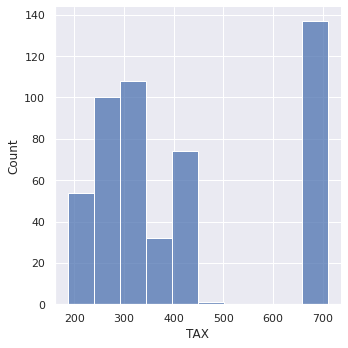

In [6]:
#6
import seaborn as sns
%matplotlib inline
sns.set()
sns.displot(df['TAX'])

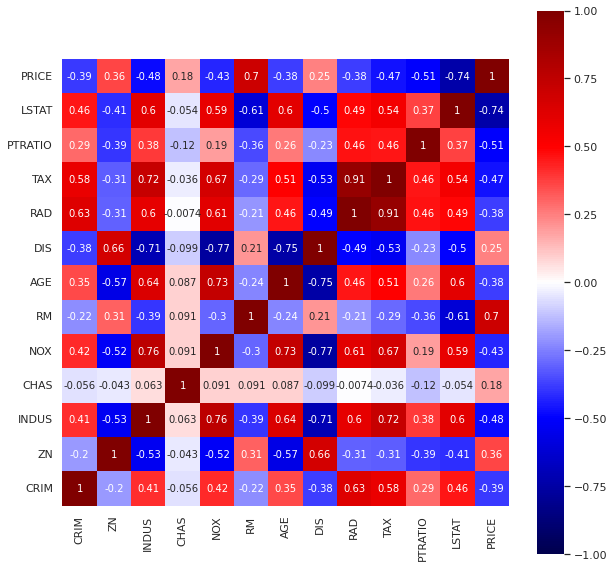

In [7]:
#7
# 相関行列の計算
correlation_coefficients = df.corr()  
# 相関行列のヒートマップ
plt.rcParams['font.size'] = 10
plt.figure(figsize=(10,10))
sns.heatmap(correlation_coefficients, vmax=1, vmin=-1, cmap='seismic',annot=True , square=True, xticklabels=1, yticklabels=1)
plt.xlim([0, correlation_coefficients.shape[0]])
plt.ylim([0, correlation_coefficients.shape[0]])
plt.show()

### **2. 2種類の機械学習モデルを作成しましょう**

**２-1. モデルの違いによる傾向の確認**

機械学習において、何でもできる万能アルゴリズムは今のところ存在しないことから、異なるアルゴリズムや変数での実行結果の違いを確認することは有用な方法である．一般的には全般的な傾向を掴む目的で線形モデルを活用し、高い予測精度が求められる実用では非線形モデルを使うという考え方が良いと考えられる．また、同じデータセットに対して2つの異なるアルゴリズムが類似した結果であると、正しく学習できているという確認にも繋がる．

- 線形モデル：人が理解しやすい特徴量を使うことで、モデルが学習した対象の振る舞いを説明することができる．ただし、予測精度が低い場合が多い．

- 非線形モデル：人が理解するのは困難であるが、より正確な予測を実行するモデルが作れる．


In [93]:
#8
train_data, test_data = train_test_split(df, test_size = 0.3)
target_train, target_test =  train_data['PRICE'], test_data['PRICE'] 
features_train, features_test = train_data.drop('PRICE', axis = 1 ),test_data.drop('PRICE', axis = 1 )

In [94]:
#9
# Linear regression
linear = ElasticNet(alpha = 1).fit(features_train, target_train)
# Nonlinear regression
nonlinear = lgb.LGBMRegressor().fit(features_train, target_train)

### **3. 回帰モデルの評価　＆　解釈しましょう**

**3-1. 回帰モデルの評価指標**

- MAE(Mean Absolute Error): 予測と正解の絶対値誤差であり、小さいほど精度が良いことを示す．また、誤差割合にしたのがMAPE(Mean Absolute Percentage　Error)である．RMSEに比べて、誤差値の単位が元の目的変数と同じであるため絶対的な誤差の大きさを理解しやすい．
- RMSE(Root Mean Square Error): 予測と正解の平均二乗誤差であり、小さいほど精度が良いことを示す．誤差割合にしたのが、RMSPE(Root Mean Square Percentage Error)である．MAEと比べて、全体的な、ずれの大きさを把握することができる．
- R2 Score：決定係数と呼ばれるデータに対するモデルの当てはまりの良さを表現する値である．１に近いほど当てはまり度合いが高く、説明変数が目的変数をどれぐらい説明できているかの指標として使われる．

In [95]:
#10
import ipywidgets as ipw

# Prediction and evaluation
models = {'linear' : linear, 'nonlinear' : nonlinear}

df_evals = pd.DataFrame()
df_graph = pd.Series(dtype = 'object')
df_shap = pd.Series(dtype = 'object')

for idx in models.keys():
    
    target_pred = models[idx].predict(features_test)
    
    mae = mean_absolute_error(target_test, target_pred)
    r2 = r2_score(target_test, target_pred)
    
    df_temp = pd.DataFrame( {'R2':r2 ,'MAE':mae}, index = [idx])
    df_evals = df_evals.append(df_temp)
    df_graph[idx] = go.Scatter(x= target_test, y= target_pred, mode='markers', name=idx)
    

**3-2. モデル間の違いについての考察**

Boston Housingの性能評価の結果を見ると、モデル間の違いにより以下のような考察ができる．

- **線形モデル／非線形モデルでの違い：** 予測結果は、線形モデルより非線形モデルの方が、RMSPEで15%以上も精度が高いことがわかる．これは、住宅価格の予測問題にはカテゴリ変数が含まれているため、単純な線形モデルではデータに対しての表現力が弱いことが一因であると考えられる．特に、高価格帯での線形モデルの精度が悪化している点に関しては、データ確認の章で述べたように最大価格帯でのデータが影響していることが考えられる．つまり、実データにおいて指数的に価格増加する価格増加を線形モデルでは適切に当てはめることができていない．


- **特徴量選択の有無での違い：** 特徴量選択の有無に関して、線形モデルと非線形モデルの双方において、特徴量選択した場合の方が、誤差が小さくなっている．重要な特徴量に絞って学習することで、テストデータに対して、汎化性能が向上したと考えられる．なお、特徴量選択有(Linear_L1)と特徴量選択無(Linear)がRMSEとRMSPEで結果が逆転していることにも注意が必要である．これは特徴量選択有の方は、低価格帯で予測誤差が大きいためで、RMSPEでは正解データに対して誤差率(%)を取るため、相対的な影響が表れていることが理由である．

このように、モデルの予測精度は単独の指標だけで検討することが難しく、複数の指標を比べながらデータ分析を進める必要がある．


In [96]:
#11
display (df_evals)
legend = dict(xanchor = 'left', yanchor ='top', orientation = 'h')
fig1 = go.FigureWidget([df_graph['linear'], df_graph['nonlinear']]).update_layout(width = 400, height = 400,legend=legend)

,R2,MAE
linear,0.703631,3.659550
nonlinear,0.911232,2.064643


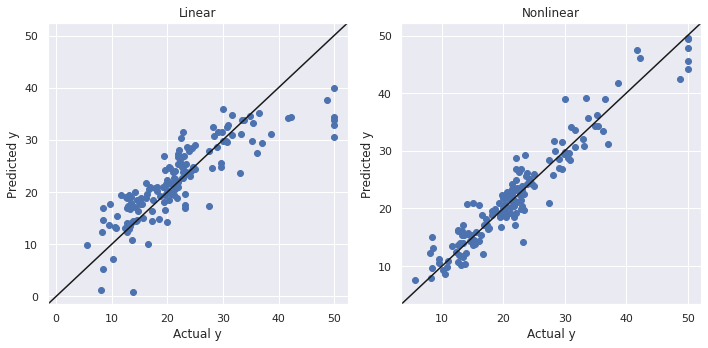

In [97]:
#12
pred_linear = linear.predict(features_test)
pred_nonlinear = nonlinear.predict(features_test)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(target_test, pred_linear)
y_max = max(target_test.max(), pred_linear.max())
y_min = min(target_test.min(), pred_linear.min())
plt.plot([y_min-0.05*(y_max-y_min), y_max+0.05*(y_max-y_min)], [y_min-0.05*(y_max-y_min), y_max+0.05*(y_max-y_min)], 'k-')
plt.xlim(y_min-0.05*(y_max-y_min), y_max+0.05*(y_max-y_min))
plt.ylim(y_min-0.05*(y_max-y_min), y_max+0.05*(y_max-y_min))
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('Linear')

plt.subplot(1,2,2)
plt.scatter(target_test, pred_nonlinear)
y_max = max(target_test.max(), pred_nonlinear.max())
y_min = min(target_test.min(), pred_nonlinear.min())
plt.plot([y_min-0.05*(y_max-y_min), y_max+0.05*(y_max-y_min)], [y_min-0.05*(y_max-y_min), y_max+0.05*(y_max-y_min)], 'k-')
plt.xlim(y_min-0.05*(y_max-y_min), y_max+0.05*(y_max-y_min))
plt.ylim(y_min-0.05*(y_max-y_min), y_max+0.05*(y_max-y_min))
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('Nonlinear')
plt.tight_layout()
plt.show()

### **4. モデル解釈**

**4-1. SHAP値によるモデル解釈**\
最後に、SHAP値を使ったモデルの解釈について、特徴量選択有で構築したモデルを使って説明する．SHAP値は、各データサンプルにおける特徴量の貢献度を数値化した値で、特徴量がポジティブもしくはネガティブに効いているかが判断できる．下の図は、テストデータに対してSHAP値を算出したグラフである．

**4-2. Boston Housingでの解釈例**\
線形・非線形モデルともに、LSTAT「低所得者人口の割合」が多ければ多いほど、価格が安いという結果になっており、この特徴量がもっとも関係性が強いことがわかる．その他は、線形・非線形で重要度は異なるが、RM「部屋数」が多いほど価格が高い、DIS「雇用センターまでの距離」が遠く価格が安い(おそらくダウンタウンから離れる)、PTRATIO「生徒と先生の比率」が大きくなると価格が安い(生徒が多い地域は教育レベル低い)、CRIM「犯罪率」が高い場合はマイナスの影響し、低い場合は価格と関係ないといった点は、直感的に正しいと考えられる．また、非線形モデルでは、NOX「一酸化窒素濃度」が大きいと価格が安くなるという傾向を捉えており、環境が影響していることが読み取れる．
一方で、TAX「固定資産税率」は線形・非線形で違う傾向を示しており、税率が低いと価格が下がる傾向があることは同じであるが、線形モデルでは税率が高いと価格が下がるという矛盾した結果になっている．このように線形モデルでは論理的に納得できない内容を含んでおり、特定の住宅に対しては誤った結果を出している可能性がある．

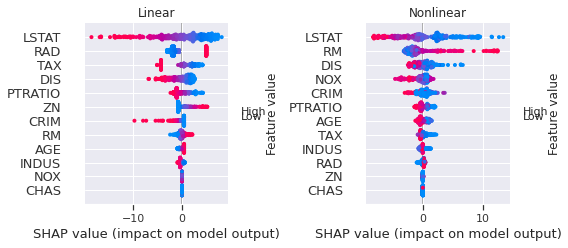

In [98]:
#13
plt.figure()
plt.subplot(2,2,1)
explainer = shap.LinearExplainer(linear, masker = features_train) ##　線形モデルへの説明付加
shap_values = explainer.shap_values(features_train)
shap.summary_plot(shap_values = shap_values, features = features_train, feature_names = features_train.columns, show=False)
plt.title('Linear')

plt.subplot(2,2,2)
explainer = shap.TreeExplainer(nonlinear, data = features_train)  ## 非線形モデルへの説明付加
shap_values = explainer.shap_values(features_train)
shap.summary_plot(shap_values = shap_values, features = features_train, feature_names = features_train.columns, show=False)
plt.title('Nonlinear')

plt.tight_layout()
plt.show()


**4-3. 最後に**\
機械学習では、教師データに対して誤差が小さくなるように特徴量の重みを決めており、データ上の辻褄あわせの発生で誤ったことを重要と捉える場合がある．このため、上記のように矛盾していないかを分析者自身がモデルを解釈して確認することが重要であり、論理的に正しいと納得できるモデルである場合に限って、信頼して業務で利用できる品質であると考えることが重要である．


### **5. 回帰モデルを使ってPRICEを予測する**

**5-1. 作成した機械学習モデルで予測を行う**
#### 今回は、CRIMを0.08(下位25％の値)、TAXを279(下位25％の値)にして、それ以外を中央値にしました。
##### つまり、犯罪率と固定資産がとても低くて、それ以外は真ん中のエリアの住宅価格を予測します。
###### ↓はそれぞれの変数の中央値
##### [CRIM	,ZN	,INDUS	,CHAS	,NOX	,RM	,AGE	,DIS	,RAD	,TAX	,PTRATIO	,LSTAT]
##### [0.25651	,0	,9.69	,0	,0.538	,6.2085	,77.5	,3.20745	,5	,330	,19.05	,11.36]

In [99]:
#14
predict_nonlinear = nonlinear.predict([[0.08 ,0 ,9.69 ,0 ,0.538 ,6.2085 ,77.5 ,3.20745 ,5 ,279 ,19.05 ,11.36]])
predict_linear = linear.predict([[      0.08 ,0 ,9.69 ,0 ,0.538 ,6.2085 ,77.5 ,3.20745 ,5 ,279 ,19.05 ,11.36]])

predict_price = []
predict_price.append(predict_linear)
predict_price.append(predict_nonlinear)
predict_price = pd.DataFrame(predict_price).T
predict_price.columns = ['price_linear','price_nonlinear']
display(predict_price)

,price_linear,price_nonlinear
0,24.305776,20.957417


# 【おまけ】モデルを可視化

### LSTAT, RM の２変数だけ可変にした時のモデルを可視化(非線形)

In [100]:
#12変数あった多変量非線形回帰モデルの変数を、10個は中央値を入力して固定し、CRIMの1変数だけ可変にした時の予測値を返す関数を定義した。
def convert_to_1_variable_function(x):
    return nonlinear.predict([[0.25 ,0 ,9.69 ,0 ,0.538 ,6.2085 ,77.5 ,3.20745 ,5 ,279 ,19.05 ,x]])

#12変数あった多変量非線形回帰モデルの変数を、10個は中央値を入力して固定し、CRIM,RMの2変数だけ可変にした時の予測値を返す関数を定義した。
def convert_to_2_variable_function(x,y):
    return nonlinear.predict([[0.25 ,0 ,9.69 ,0 ,0.538 ,y ,77.5 ,3.20745 ,5 ,279 ,19.05 ,x]])



In [16]:
#グリッド（座標みたいなイメージの配列）を作成した。
#ｘ方向には、0～10までの範囲で、10点の値を等差で生成した。
#y方向にも、0～10までの範囲で、10点の値を等差で生成した。
#meshgridによって、0～10までの範囲のX,Y座標を作り、その座標を10＊10マスに区切り、その全ての座標についての値を生成した。
#gx、gyは100行のリストが生成されており、それぞれのリストの要素数は10である。（10＊10マスの行列）
#gxは左の列が全て0で、右に進むにつれて値が大きくなり、最右の列は全て10である。
#gyは上の列が全て0で、下に進むにつれて値が大きくなり、最下の列は全て10である。
#この様にして、0～10の範囲のX,Y座標を作成し、その座標には合計1万点のデータを用意した。

from numpy import *
x = linspace(0,10,10)
y = linspace(0,10,10)
gx, gy = meshgrid(x,y)

In [17]:
#gxの配列のイメージ
gx

array([[ 0.        ,  1.11111111,  2.22222222,  3.33333333,  4.44444444,
         5.55555556,  6.66666667,  7.77777778,  8.88888889, 10.        ],
       [ 0.        ,  1.11111111,  2.22222222,  3.33333333,  4.44444444,
         5.55555556,  6.66666667,  7.77777778,  8.88888889, 10.        ],
       [ 0.        ,  1.11111111,  2.22222222,  3.33333333,  4.44444444,
         5.55555556,  6.66666667,  7.77777778,  8.88888889, 10.        ],
       [ 0.        ,  1.11111111,  2.22222222,  3.33333333,  4.44444444,
         5.55555556,  6.66666667,  7.77777778,  8.88888889, 10.        ],
       [ 0.        ,  1.11111111,  2.22222222,  3.33333333,  4.44444444,
         5.55555556,  6.66666667,  7.77777778,  8.88888889, 10.        ],
       [ 0.        ,  1.11111111,  2.22222222,  3.33333333,  4.44444444,
         5.55555556,  6.66666667,  7.77777778,  8.88888889, 10.        ],
       [ 0.        ,  1.11111111,  2.22222222,  3.33333333,  4.44444444,
         5.55555556,  6.66666667,  7.77777778

In [18]:
#gyの配列のイメージ
gy

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.11111111,  1.11111111,  1.11111111,  1.11111111,  1.11111111,
         1.11111111,  1.11111111,  1.11111111,  1.11111111,  1.11111111],
       [ 2.22222222,  2.22222222,  2.22222222,  2.22222222,  2.22222222,
         2.22222222,  2.22222222,  2.22222222,  2.22222222,  2.22222222],
       [ 3.33333333,  3.33333333,  3.33333333,  3.33333333,  3.33333333,
         3.33333333,  3.33333333,  3.33333333,  3.33333333,  3.33333333],
       [ 4.44444444,  4.44444444,  4.44444444,  4.44444444,  4.44444444,
         4.44444444,  4.44444444,  4.44444444,  4.44444444,  4.44444444],
       [ 5.55555556,  5.55555556,  5.55555556,  5.55555556,  5.55555556,
         5.55555556,  5.55555556,  5.55555556,  5.55555556,  5.55555556],
       [ 6.66666667,  6.66666667,  6.66666667,  6.66666667,  6.66666667,
         6.66666667,  6.66666667,  6.66666667

In [19]:
#gx,gyで作成した100＊100マスの座標にある1万点のデータを入力した時の予測値gzを算出するためにfor文を使う
#そのために、gx,gy其々の配列を2次元配列から1次元配列へと平坦化する。

import itertools

gx_flatten = list(itertools.chain.from_iterable(gx))
gy_flatten = list(itertools.chain.from_iterable(gy))

In [20]:
#gx,gyともに、100＊100の行列データなので、それのデータ数はそれぞれ1万である。
print(len(gx_flatten),len(gy_flatten))

100 100


In [21]:
#平坦化されたgxのイメージ
gy_flatten

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.1111111111111112,
 1.1111111111111112,
 1.1111111111111112,
 1.1111111111111112,
 1.1111111111111112,
 1.1111111111111112,
 1.1111111111111112,
 1.1111111111111112,
 1.1111111111111112,
 1.1111111111111112,
 2.2222222222222223,
 2.2222222222222223,
 2.2222222222222223,
 2.2222222222222223,
 2.2222222222222223,
 2.2222222222222223,
 2.2222222222222223,
 2.2222222222222223,
 2.2222222222222223,
 2.2222222222222223,
 3.3333333333333335,
 3.3333333333333335,
 3.3333333333333335,
 3.3333333333333335,
 3.3333333333333335,
 3.3333333333333335,
 3.3333333333333335,
 3.3333333333333335,
 3.3333333333333335,
 3.3333333333333335,
 4.444444444444445,
 4.444444444444445,
 4.444444444444445,
 4.444444444444445,
 4.444444444444445,
 4.444444444444445,
 4.444444444444445,
 4.444444444444445,
 4.444444444444445,
 4.444444444444445,
 5.555555555555555,
 5.555555555555555,
 5.555555555555555,
 5.555555555555555,
 5.555555555555555,
 5.5555555

In [101]:
#それでは平坦化したgx,gyを1セットにして、0番目から100番目までfor文で順番に、2変数化した予測モデルへと代入して、それぞれの座標での予測値を出力する
#それをgz_flattenというリストに格納する。合計で100点の予測値が1次元配列で保存されることになる。
#もうfor文は使わないので、gz_flattenは1次元配列である必要はない。そこで100＊100マスの座標の形に直す為、リストを配列へと変換する処理をしてから、要素数100の100列のリストを持つ配列へと成形する
#これでめでたく、gx,gy,gzの値がグリッドとして準備できた。

gz_flatten = []

for (x, y) in zip(gx_flatten,gy_flatten):
    num = convert_to_2_variable_function(x,y)
    gz_flatten.extend(num)
    

arr_gz_flatten = np.array(gz_flatten)
arr_gz_flatten
gz = arr_gz_flatten.reshape(10,10)
gz

array([[28.87679447, 28.87679447, 28.87679447, 28.87679447, 25.84415702,
        21.20502715, 21.74560794, 21.85938064, 22.93640674, 18.57266655],
       [28.87679447, 28.87679447, 28.87679447, 28.87679447, 25.84415702,
        21.20502715, 21.74560794, 21.85938064, 22.93640674, 18.57266655],
       [28.87679447, 28.87679447, 28.87679447, 28.87679447, 25.84415702,
        21.20502715, 21.74560794, 21.85938064, 22.93640674, 18.57266655],
       [28.87679447, 28.87679447, 28.87679447, 28.87679447, 25.84415702,
        21.20502715, 21.74560794, 21.85938064, 22.93640674, 18.57266655],
       [28.87679447, 28.87679447, 28.87679447, 28.87679447, 25.84415702,
        21.20502715, 21.74560794, 21.85938064, 22.93640674, 18.57266655],
       [28.87679447, 28.87679447, 28.87679447, 28.87679447, 25.84415702,
        21.20502715, 21.74560794, 21.85938064, 22.85328306, 18.48954287],
       [29.95792558, 29.95792558, 29.95792558, 29.95792558, 27.1042565 ,
        23.91133671, 24.55880525, 24.55880525

In [78]:
#gx,gy,gzのグリッドを可視化する
from matplotlib.pyplot import *
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib notebook

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning:

Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.



Text(0.5, 0, 'PRICE')

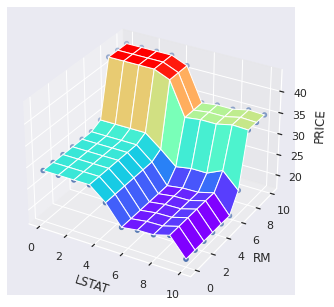

In [187]:
ax = Axes3D(figure())
ax.scatter3D(gx, gy, gz)
ax.plot_surface(gx,gy,gz,cmap='rainbow')
# 軸ラベルの設定
ax.set_xlabel("LSTAT")
ax.set_ylabel("RM")
ax.set_zlabel("PRICE")

#plt.xlabel("LSTAT") # x軸ラベル
#plt.ylabel("RM") # y軸ラベル
#plt.zlabel("PRICE") # z軸ラベル

### LSTAT, RM の２変数だけ可変にした時のモデルを可視化(線形)

In [177]:
#12変数あった多変量非線形回帰モデルの変数を、10個は中央値を入力して固定し、CRIMの1変数だけ可変にした時の予測値を返す関数を定義した。
def linear_convert_to_1_variable_function(x):
    return linear.predict([[0.25 ,0 ,9.69 ,0 ,0.538 ,6.2085 ,77.5 ,3.20745 ,5 ,279 ,19.05 ,x]])

#12変数あった多変量非線形回帰モデルの変数を、10個は中央値を入力して固定し、CRIM,RMの2変数だけ可変にした時の予測値を返す関数を定義した。
def linear_convert_to_2_variable_function(x,y):
    return linear.predict([[0.25 ,0 ,9.69 ,0 ,0.538 ,y ,77.5 ,3.20745 ,5 ,279 ,19.05 ,x]])

In [180]:
gz_linear_flatten = []

for (x, y) in zip(gx_flatten,gy_flatten):
    num = linear_convert_to_2_variable_function(x,y)
    gz_linear_flatten.extend(num)
    

arr_gz_linear_flatten = np.array(gz_linear_flatten)
arr_gz_linear_flatten
gz_linear = arr_gz_linear_flatten.reshape(10,10)
gz_linear

array([[27.50600459, 26.65813984, 25.8102751 , 24.96241035, 24.1145456 ,
        23.26668086, 22.41881611, 21.57095137, 20.72308662, 19.87522188],
       [28.48116782, 27.63330307, 26.78543833, 25.93757358, 25.08970883,
        24.24184409, 23.39397934, 22.5461146 , 21.69824985, 20.85038511],
       [29.45633105, 28.6084663 , 27.76060156, 26.91273681, 26.06487206,
        25.21700732, 24.36914257, 23.52127783, 22.67341308, 21.82554834],
       [30.43149428, 29.58362953, 28.73576479, 27.88790004, 27.0400353 ,
        26.19217055, 25.3443058 , 24.49644106, 23.64857631, 22.80071157],
       [31.40665751, 30.55879276, 29.71092802, 28.86306327, 28.01519853,
        27.16733378, 26.31946903, 25.47160429, 24.62373954, 23.7758748 ],
       [32.38182074, 31.53395599, 30.68609125, 29.8382265 , 28.99036176,
        28.14249701, 27.29463226, 26.44676752, 25.59890277, 24.75103803],
       [33.35698397, 32.50911922, 31.66125448, 30.81338973, 29.96552499,
        29.11766024, 28.2697955 , 27.42193075

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning:

Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.



Text(0.5, 0, 'PRICE')

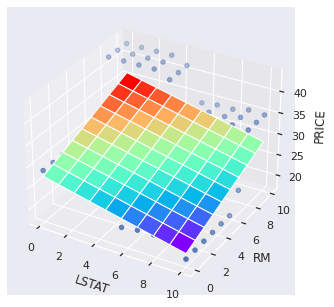

In [186]:
ax = Axes3D(figure())
ax.scatter3D(gx, gy, gz)
ax.plot_surface(gx,gy,gz_linear,cmap='rainbow')

# 軸ラベルの設定
ax.set_xlabel("LSTAT")
ax.set_ylabel("RM")
ax.set_zlabel("PRICE")


### CRIMの１変数だけ可変にした時のモデルを可視化(線形)

In [161]:
x = linspace(0,35,100)
x

array([ 0.        ,  0.35353535,  0.70707071,  1.06060606,  1.41414141,
        1.76767677,  2.12121212,  2.47474747,  2.82828283,  3.18181818,
        3.53535354,  3.88888889,  4.24242424,  4.5959596 ,  4.94949495,
        5.3030303 ,  5.65656566,  6.01010101,  6.36363636,  6.71717172,
        7.07070707,  7.42424242,  7.77777778,  8.13131313,  8.48484848,
        8.83838384,  9.19191919,  9.54545455,  9.8989899 , 10.25252525,
       10.60606061, 10.95959596, 11.31313131, 11.66666667, 12.02020202,
       12.37373737, 12.72727273, 13.08080808, 13.43434343, 13.78787879,
       14.14141414, 14.49494949, 14.84848485, 15.2020202 , 15.55555556,
       15.90909091, 16.26262626, 16.61616162, 16.96969697, 17.32323232,
       17.67676768, 18.03030303, 18.38383838, 18.73737374, 19.09090909,
       19.44444444, 19.7979798 , 20.15151515, 20.50505051, 20.85858586,
       21.21212121, 21.56565657, 21.91919192, 22.27272727, 22.62626263,
       22.97979798, 23.33333333, 23.68686869, 24.04040404, 24.39

In [108]:
z = []

for idx in x:
    num = convert_to_1_variable_function(idx)
    z.extend(num)

z

[29.411150272529596,
 29.411150272529596,
 29.411150272529596,
 29.411150272529596,
 29.411150272529596,
 29.411150272529596,
 29.411150272529596,
 29.411150272529596,
 29.411150272529596,
 29.411150272529596,
 29.411150272529596,
 29.411150272529596,
 26.557481188785196,
 27.104045997062165,
 26.03160834585696,
 22.575871236546543,
 22.575871236546543,
 22.629806094628037,
 23.163024108185144,
 23.223339778543394,
 23.33711247378244,
 23.33711247378244,
 23.33711247378244,
 23.568070052278802,
 23.568070052278802,
 25.044262228089828,
 25.47029813612647,
 23.52166840341127,
 20.43882862481486,
 20.625964421488312,
 20.746387851277657,
 20.787271417991203,
 20.787271417991203,
 20.787271417991203,
 20.746465539069458,
 20.799148893567324,
 20.893533493467466,
 20.91031803874465,
 21.06714878599279,
 21.284441599126417,
 21.108381967948414,
 21.146724134169613,
 21.24716883548708,
 21.18714375774643,
 21.18714375774643,
 21.18714375774643,
 21.058272519690508,
 20.94684951453055,
 20.89

In [109]:
val = list(zip(x,z))
val
df_1val = pd.DataFrame(val, columns = ['LSTAT','PRICE'])
df_1val

,LSTAT,PRICE
0,0.000000,29.411150
1,0.353535,29.411150
2,0.707071,29.411150
3,1.060606,29.411150
4,1.414141,29.411150
...,...,...
95,33.585859,19.801405
96,33.939394,19.801405
97,34.292929,19.801405
98,34.646465,19.801405


Text(0, 0.5, 'PRICE')

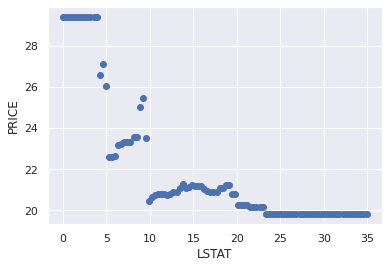

In [120]:
scatter(x,z)
plt.xlabel("LSTAT") # x軸ラベル
plt.ylabel("PRICE") # y軸ラベル

In [111]:
def model(x,a,b):
    return x*a +b

In [112]:
from scipy.optimize import curve_fit

In [113]:
param, covar = curve_fit(model,x,z)

Text(0, 0.5, 'PRICE')

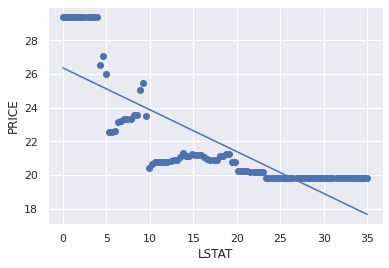

In [114]:
z_fit = model(x, param[0], param[1])
scatter(x, z)
plot(x,z_fit)
plt.xlabel("LSTAT") # x軸ラベル
plt.ylabel("PRICE") # y軸ラベル

In [115]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(color_codes=True)


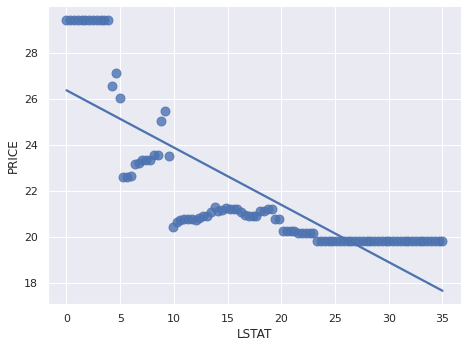

In [122]:
sns.lmplot(x="LSTAT", y="PRICE", data=df_1val, order=0, ci=None, scatter_kws={"s": 80}, aspect=4/3)

plt.show()

### CRIMの１変数だけ可変にした時のモデルを可視化(非線形)

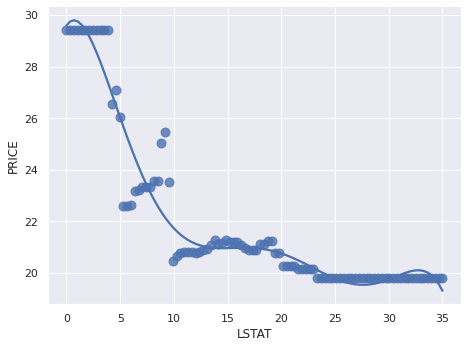

In [193]:
sns.lmplot(x="LSTAT", y="PRICE", data=df_1val, order=6, ci=None, scatter_kws={"s":80},aspect=4/3)

plt.show()

# 参考サイト

#### 最小二乗法による2変数関数フィッティング
###### https://www.youtube.com/watch?v=ZGz00aKNWfM&t=340s
#### Pythonで基礎から機械学習 「重回帰分析」
###### https://qiita.com/karaage0703/items/f38d18afc1569fcc0418
#### Python seaborn チュートリアル プロット機能 回帰モデルを可視化 (2)
###### https://hawk-tech-blog.com/python-learn-seaborn-tutorial-plotting-function-regression-models-2/
#### pandas.DataFrame, Seriesを連結するconcat
###### https://note.nkmk.me/python-pandas-concat/
#### 正規化・標準化を徹底解説 （Python 前処理 サンプルコード付き）
###### https://www.codexa.net/normalization-python/
#### NumPyのarange, linspaceの使い方（連番や等差数列を生成）
###### https://note.nkmk.me/python-numpy-arange-linspace/
#### Pythonで複数のリストを同時にfor文で回す
###### https://qiita.com/taku_hito/items/b78b06c42cb0c28af16e
#### Python Pandas：リストをデータフレームに変換する方法
###### https://tech-branch.9999ch.com/archives/408
#### NumPy配列ndarrayとPython標準のリストを相互に変換
###### https://note.nkmk.me/python-numpy-list/
#### Pythonでflatten（多次元リストを一次元に平坦化）
###### https://note.nkmk.me/python-list-flatten/